# Trabajo Final - Series de Tiempo 2
## Analisis Comparativo de Modelos para Bitcoin Forecasting

**Universidad de Buenos Aires - Facultad de Ingenieria - LSE**  
**Docente:** Camilo Argoty  
**Especializacion:** Inteligencia Artificial  
**Curso:** Analisis de Series de Tiempo

---

### Version 3: Importacion de Modelos desde src/models/
Este notebook utiliza las arquitecturas importadas directamente desde:
- `src/models/lstm_model.py`
- `src/models/transformer_model.py`
- `src/models/informer_model.py`

In [1]:
# Importaciones basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Seeds
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA: {torch.cuda.is_available()}")

# Config
CONFIG = {
    'ticker': 'BTC-USD',
    'start_date': '2020-01-01',
    'end_date': '2024-11-01',
    'train_ratio': 0.80,
    'forecast_horizons': [7, 14, 30],
    'output_dir': 'final_st2_results_v3',
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)
print(f"\nResultados en: {CONFIG['output_dir']}/")

PyTorch: 2.9.0+cpu
Device: cpu
CUDA: False

Resultados en: final_st2_results_v3/


## Importar Modelos desde src/models/

En esta version importamos las arquitecturas de modelos directamente desde el modulo `src.models`.

In [2]:
# Agregar el directorio raiz al path para importar los modulos
sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

# Import LSTM architecture
from src.models.lstm_model import (
    LSTMModel,
    ModelTrainer as LSTMTrainer,
    Evaluator as LSTMEvaluator
)

# Import Transformer architecture
from src.models.transformer_model import (
    Transformer,
    ImprovedTrainer,
    ImprovedEvaluator
)

# Import Informer architecture
from src.models.informer_model import (
    Informer,
    ImprovedInformerTrainer,
    ImprovedInformerEvaluator
)

print("Modelos importados exitosamente desde src/models/:")
print("  - LSTMModel")
print("  - Transformer")
print("  - Informer")

Modelos importados exitosamente desde src/models/:
  - LSTMModel
  - Transformer
  - Informer


## 1. Carga de Datos

In [3]:
print("Descargando Bitcoin...")
data = yf.download(CONFIG['ticker'], 
                   start=CONFIG['start_date'], 
                   end=CONFIG['end_date'],
                   progress=False)

print(f"\nDatos: {len(data)} observaciones")
print(f"Periodo: {data.index[0].date()} a {data.index[-1].date()}")
print(f"\nPrimeras filas:")
data.head()

Descargando Bitcoin...

Datos: 1766 observaciones
Periodo: 2020-01-01 a 2024-10-31

Primeras filas:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [4]:
# Estadisticas
print("ESTADISTICAS")
print(f"Precio inicial: ${float(data['Close'].iloc[0]):,.2f}")
print(f"Precio final:   ${float(data['Close'].iloc[-1]):,.2f}")
print(f"Precio minimo:  ${float(data['Close'].min()):,.2f}")
print(f"Precio maximo:  ${float(data['Close'].max()):,.2f}")
print(f"Precio promedio: ${float(data['Close'].mean()):,.2f}")

returns_total = ((float(data['Close'].iloc[-1]) / float(data['Close'].iloc[0])) - 1) * 100
print(f"\nRetorno total: {returns_total:+.2f}%")

daily_returns = data['Close'].pct_change().dropna()
volatility = float(daily_returns.std() * np.sqrt(252) * 100)
print(f"Volatilidad anualizada: {volatility:.2f}%")

ESTADISTICAS
Precio inicial: $7,200.17
Precio final:   $70,215.19
Precio minimo:  $4,970.79
Precio maximo:  $73,083.50
Precio promedio: $34,376.83

Retorno total: +875.19%
Volatilidad anualizada: 53.50%


In [5]:
# Train/Test split
split_idx = int(len(data) * CONFIG['train_ratio'])
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Train: {len(train_data)} obs ({CONFIG['train_ratio']*100:.0f}%)")
print(f"Test:  {len(test_data)} obs ({(1-CONFIG['train_ratio'])*100:.0f}%)")

Train: 1412 obs (80%)
Test:  354 obs (20%)


## 2. Visualizacion EDA

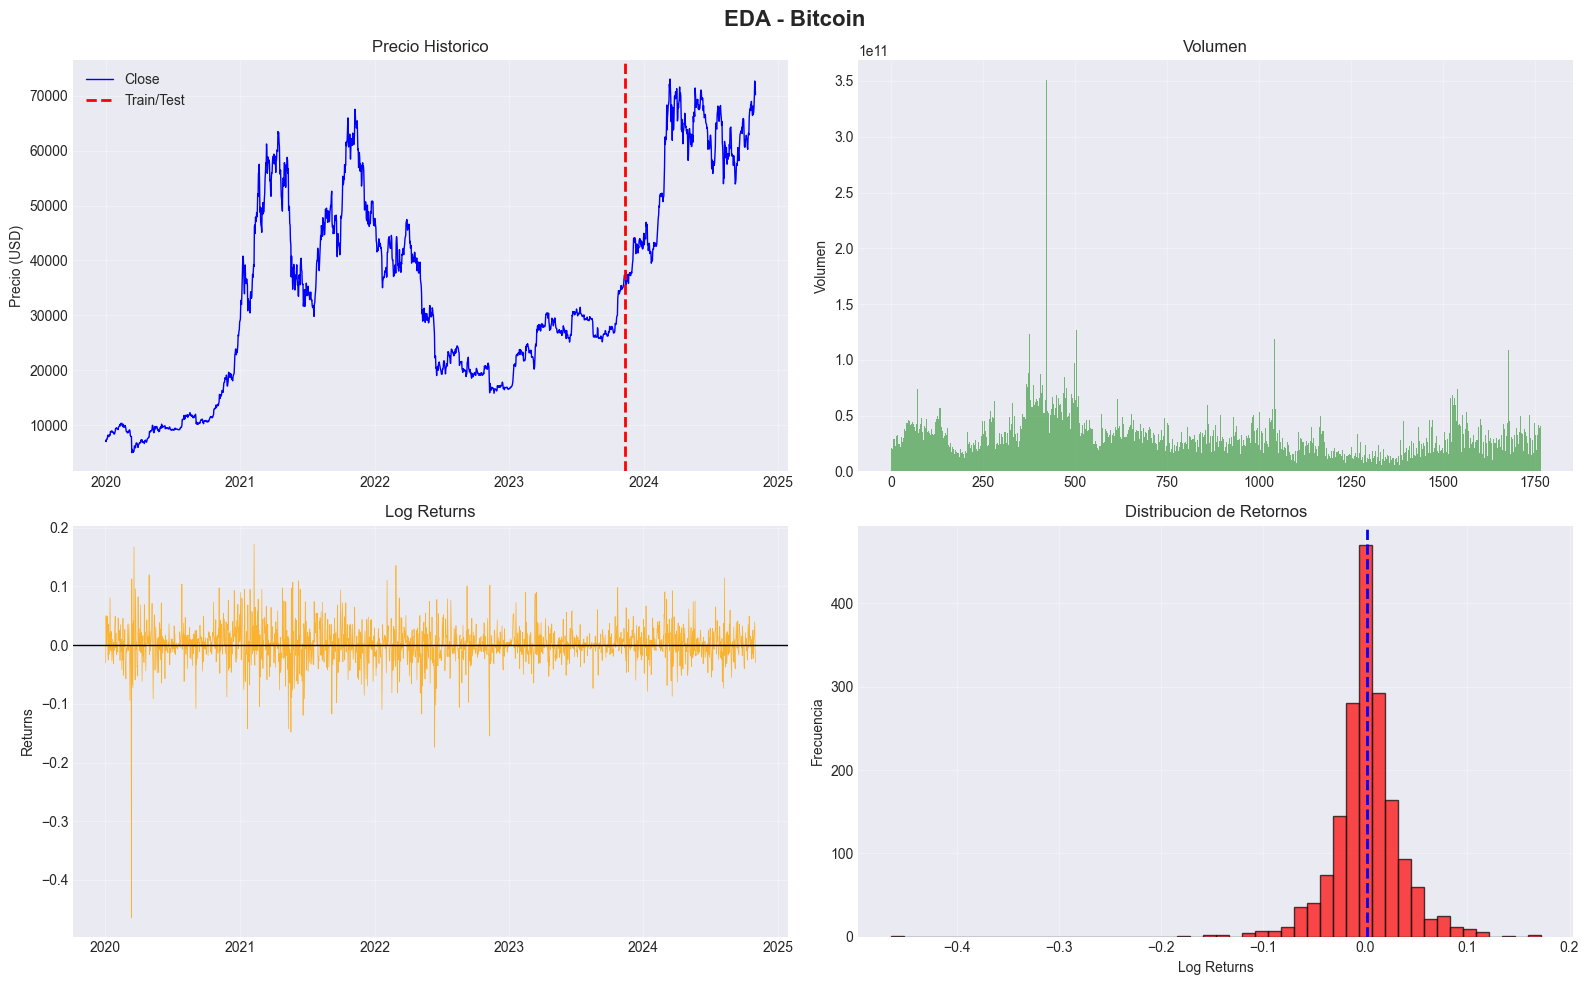

EDA guardado.


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('EDA - Bitcoin', fontsize=16, fontweight='bold')

# Precio
ax = axes[0, 0]
ax.plot(data.index, data['Close'].values, linewidth=1, color='blue', label='Close')
ax.axvline(train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train/Test')
ax.set_title('Precio Historico')
ax.set_ylabel('Precio (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# Volumen
ax = axes[0, 1]
volume_values = data['Volume'].values.flatten()
ax.bar(range(len(volume_values)), volume_values, color='green', alpha=0.5, width=1)
ax.set_title('Volumen')
ax.set_ylabel('Volumen')
ax.grid(True, alpha=0.3)

# Retornos
ax = axes[1, 0]
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
ax.plot(returns.index, returns.values, linewidth=0.5, color='orange', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_title('Log Returns')
ax.set_ylabel('Returns')
ax.grid(True, alpha=0.3)

# Distribucion
ax = axes[1, 1]
ax.hist(returns.values.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
ax.axvline(float(returns.mean()), color='blue', linestyle='--', linewidth=2)
ax.set_title('Distribucion de Retornos')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/01_EDA.png", dpi=300, bbox_inches='tight')
plt.show()
print("EDA guardado.")

## 3. Tests de Estacionariedad

In [7]:
print("TESTS DE ESTACIONARIEDAD")
print("="*60)

# Precios
print("\n[1] PRECIOS (nivel 0)")
adf_result = adfuller(data['Close'].dropna())
kpss_result = kpss(data['Close'].dropna(), regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'NO ESTACIONARIO' if adf_result[1] > 0.05 else 'ESTACIONARIO'}")

# Primera diferencia
print("\n[2] PRIMERA DIFERENCIA")
diff1 = data['Close'].diff().dropna()
adf_result = adfuller(diff1)
kpss_result = kpss(diff1, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

# Log returns
print("\n[3] LOG RETURNS")
log_ret = np.log(data['Close'] / data['Close'].shift(1)).dropna()
adf_result = adfuller(log_ret)
kpss_result = kpss(log_ret, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

TESTS DE ESTACIONARIEDAD

[1] PRECIOS (nivel 0)
ADF: statistic=-1.0647, p-value=0.7289
KPSS: statistic=0.6489, p-value=0.0100
Conclusion: NO ESTACIONARIO

[2] PRIMERA DIFERENCIA
ADF: statistic=-44.0902, p-value=0.0000
KPSS: statistic=0.1060, p-value=0.1000
Conclusion: ESTACIONARIO

[3] LOG RETURNS
ADF: statistic=-13.7820, p-value=0.0000
KPSS: statistic=0.1445, p-value=0.0527
Conclusion: ESTACIONARIO


ADF: statistic=-13.7820, p-value=0.0000
KPSS: statistic=0.1445, p-value=0.0527
Conclusion: ESTACIONARIO


## 4. Modelo ARIMA

In [8]:
print("ARIMA - Auto seleccion")
best_aic = np.inf
best_order = None
best_model = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data['Close'], order=(p,d,q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p,d,q)
                    best_model = fitted
            except:
                continue

print(f"Mejor orden: {best_order}")
print(f"AIC: {best_aic:.2f}")

arima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = best_model.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    arima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"\nHorizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nARIMA completado.")

ARIMA - Auto seleccion
Mejor orden: (2, 1, 2)
AIC: 23897.66

Horizonte 7d: RMSE=839.75, MAE=727.62, R2=-0.3839

Horizonte 14d: RMSE=744.07, MAE=638.19, R2=-0.0146

Horizonte 30d: RMSE=3446.22, MAE=2392.03, R2=-0.5375

ARIMA completado.


Mejor orden: (2, 1, 2)
AIC: 23897.66

Horizonte 7d: RMSE=839.75, MAE=727.62, R2=-0.3839

Horizonte 14d: RMSE=744.07, MAE=638.19, R2=-0.0146

Horizonte 30d: RMSE=3446.22, MAE=2392.03, R2=-0.5375

ARIMA completado.


## 5. Modelo SARIMA

In [9]:
print("SARIMA")
sarima_model = SARIMAX(train_data['Close'], 
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fitted = sarima_model.fit(disp=False)
print(f"AIC: {sarima_fitted.aic:.2f}")

sarima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = sarima_fitted.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    sarima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"Horizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nSARIMA completado.")

SARIMA
AIC: 23679.88
Horizonte 7d: RMSE=818.40, MAE=713.79, R2=-0.3144
Horizonte 14d: RMSE=721.32, MAE=577.28, R2=0.0465
Horizonte 30d: RMSE=3181.76, MAE=2159.79, R2=-0.3105

SARIMA completado.


AIC: 23679.88
Horizonte 7d: RMSE=818.40, MAE=713.79, R2=-0.3144
Horizonte 14d: RMSE=721.32, MAE=577.28, R2=0.0465
Horizonte 30d: RMSE=3181.76, MAE=2159.79, R2=-0.3105

SARIMA completado.


## 6. Feature Engineering

In [10]:
def create_features(df, verbose=True):
    """Feature engineering completo"""
    if verbose:
        print("FEATURE ENGINEERING")
        print("="*60)
    
    df = df.copy()
    original_cols = len(df.columns)
    
    # Flatten columns if MultiIndex (from yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # 1. Price-based features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Price_Change'] = (df['Close'] - df['Open']) / df['Open']
    
    # Upper and Lower shadows
    open_close_max = df[['Open', 'Close']].max(axis=1)
    open_close_min = df[['Open', 'Close']].min(axis=1)
    df['Upper_Shadow'] = (df['High'] - open_close_max) / df['Close']
    df['Lower_Shadow'] = (open_close_min - df['Low']) / df['Close']
    
    # 2. Moving averages
    for window in [5, 7, 14, 21, 30, 60]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'MA_{window}_ratio'] = df['Close'] / df[f'MA_{window}']
        
    # 3. Exponential moving averages
    for span in [12, 26]:
        df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
        
    # 4. Volatility indicators
    for window in [5, 10, 20, 30]:
        df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
        df[f'ATR_{window}'] = (df['High'] - df['Low']).rolling(window=window).mean()
    
    # 5. Momentum indicators
    for period in [5, 10, 14, 21]:
        df[f'ROC_{period}'] = ((df['Close'] - df['Close'].shift(period)) / 
                               df['Close'].shift(period)) * 100
        df[f'Momentum_{period}'] = df['Close'] - df['Close'].shift(period)
    
    # 6. RSI
    for period in [14, 21]:
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # 7. MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # 8. Bollinger Bands
    for window in [20]:
        df[f'BB_Middle_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'BB_Std_{window}'] = df['Close'].rolling(window=window).std()
        df[f'BB_Upper_{window}'] = df[f'BB_Middle_{window}'] + 2 * df[f'BB_Std_{window}']
        df[f'BB_Lower_{window}'] = df[f'BB_Middle_{window}'] - 2 * df[f'BB_Std_{window}']
        df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']
        df[f'BB_Position_{window}'] = (df['Close'] - df[f'BB_Lower_{window}']) / (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}'])
    
    # 9. Volume indicators
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # 10. Lagged features
    for lag in [1, 2, 3, 5, 7]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
    
    # 11. Time-based features
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['DayOfMonth'] = df.index.day
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.values
    
    # Cyclical encoding
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    
    # Drop NaN values
    df = df.dropna()
    
    new_cols = len(df.columns)
    
    if verbose:
        print(f"Features creados: {new_cols - original_cols}")
        print(f"Total features: {new_cols}")
        print(f"Samples validos: {len(df)}")
    
    return df

# Aplicar
df_features = create_features(data.copy(), verbose=True)

# Seleccionar features (excluir time features categoricas)
exclude_cols = ['DayOfWeek', 'Month', 'Quarter', 'DayOfMonth', 'DayOfYear', 'WeekOfYear']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]
df_model = df_features[feature_cols].copy()

print(f"\nFeatures para modelo: {len(feature_cols)}")

FEATURE ENGINEERING
Features creados: 72
Total features: 77
Samples validos: 1707

Features para modelo: 71


## 7. Preparacion de Datos para Deep Learning

In [11]:
# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len, 0]  # Close price
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Configuracion DL
DL_CONFIG = {
    'seq_len': 60,
    'pred_len': 7,
    'batch_size': 32,
    'epochs': 100,
    'learning_rate': 0.001,
    'patience': 15,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
}

# Normalizar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model.values)

# Split data
n = len(scaled_data)
train_size = int(n * DL_CONFIG['train_ratio'])
val_size = int(n * DL_CONFIG['val_ratio'])

train_data_dl = scaled_data[:train_size]
val_data_dl = scaled_data[train_size:train_size + val_size]
test_data_dl = scaled_data[train_size + val_size:]

print(f"Train: {len(train_data_dl)} ({DL_CONFIG['train_ratio']*100:.0f}%)")
print(f"Val: {len(val_data_dl)} ({DL_CONFIG['val_ratio']*100:.0f}%)")
print(f"Test: {len(test_data_dl)} ({(1-DL_CONFIG['train_ratio']-DL_CONFIG['val_ratio'])*100:.0f}%)")

# Crear datasets
train_dataset = TimeSeriesDataset(train_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])
val_dataset = TimeSeriesDataset(val_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])
test_dataset = TimeSeriesDataset(test_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train: 1194 (70%)
Val: 256 (15%)
Test: 257 (15%)

Train batches: 36
Val batches: 6
Test batches: 6


## 8. Funciones de Entrenamiento y Evaluacion

In [12]:
def train_model(model, train_loader, val_loader, epochs, lr, patience, model_name):
    """Entrena un modelo con early stopping"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None
    train_losses, val_losses = [], []
    
    print(f"\n{'='*60}")
    print(f"Entrenando {model_name}")
    print(f"{'='*60}")
    print(f"Parametros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Device: {device}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output.squeeze(), batch_y.squeeze())
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train: {train_loss:.6f} Val: {val_loss:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping en epoca {epoch+1}")
            break
    
    # Restaurar mejor modelo
    model.load_state_dict(best_state)
    model = model.to(device)
    print(f"Mejor val loss: {best_val_loss:.6f}")
    
    return model, train_losses, val_losses


def evaluate_model(model, test_loader, scaler, close_idx=0):
    """Evalua modelo y calcula metricas"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            output = model(batch_x)
            predictions.append(output.cpu().numpy())
            actuals.append(batch_y.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform
    n_features = scaler.n_features_in_
    
    if len(predictions.shape) == 1:
        predictions = predictions.reshape(-1, 1)
        actuals = actuals.reshape(-1, 1)
    
    pred_rescaled = np.zeros_like(predictions)
    actual_rescaled = np.zeros_like(actuals)
    
    for i in range(predictions.shape[1]):
        pred_full = np.zeros((predictions.shape[0], n_features))
        actual_full = np.zeros((actuals.shape[0], n_features))
        
        pred_full[:, close_idx] = predictions[:, i]
        actual_full[:, close_idx] = actuals[:, i]
        
        pred_rescaled[:, i] = scaler.inverse_transform(pred_full)[:, close_idx]
        actual_rescaled[:, i] = scaler.inverse_transform(actual_full)[:, close_idx]
    
    # Calcular metricas
    metrics = {}
    for i in range(pred_rescaled.shape[1]):
        pred = pred_rescaled[:, i]
        actual = actual_rescaled[:, i]
        
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        
        metrics[f'Day_{i+1}'] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    
    return pred_rescaled, actual_rescaled, metrics

print("Funciones de entrenamiento y evaluacion definidas.")

Funciones de entrenamiento y evaluacion definidas.


## 9. Entrenar LSTM (Importado de src/models/lstm_model.py)

In [13]:
print("LSTM (Arquitectura de src/models/lstm_model.py)")

# Crear modelo LSTM usando la clase importada
lstm_model = LSTMModel(
    input_dim=len(feature_cols),
    hidden_dim=128,
    num_layers=3,
    pred_len=DL_CONFIG['pred_len'],
    dropout=0.1
)

# Entrenar
lstm_model, lstm_train_losses, lstm_val_losses = train_model(
    lstm_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=DL_CONFIG['learning_rate'],
    patience=DL_CONFIG['patience'],
    model_name="LSTM"
)

# Evaluar
close_idx = feature_cols.index('Close')
lstm_pred, lstm_actual, lstm_metrics = evaluate_model(lstm_model, test_loader, scaler, close_idx)

print("\nLSTM Metricas:")
for day, m in lstm_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(lstm_model.state_dict(), f"{CONFIG['output_dir']}/lstm_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/lstm_model.pth")

LSTM (Arquitectura de src/models/lstm_model.py)

Entrenando LSTM
Parametros: 376,071
Device: cpu
Epoch [10/100] Train: 0.017441 Val: 0.038870
Early stopping en epoca 19
Mejor val loss: 0.017138

LSTM Metricas:
  Day_1: RMSE=9104.61, R2=-4.1767
  Day_2: RMSE=10098.42, R2=-5.3380
  Day_3: RMSE=11144.10, R2=-6.6635
  Day_4: RMSE=11512.11, R2=-7.0692
  Day_5: RMSE=12162.77, R2=-7.7639
  Day_6: RMSE=12647.51, R2=-8.2765
  Day_7: RMSE=13688.35, R2=-9.7416

Modelo guardado: final_st2_results_v3/lstm_model.pth



Entrenando LSTM
Parametros: 376,071
Device: cpu


Epoch [10/100] Train: 0.017441 Val: 0.038870


Early stopping en epoca 19
Mejor val loss: 0.017138

LSTM Metricas:
  Day_1: RMSE=9104.61, R2=-4.1767
  Day_2: RMSE=10098.42, R2=-5.3380
  Day_3: RMSE=11144.10, R2=-6.6635
  Day_4: RMSE=11512.11, R2=-7.0692
  Day_5: RMSE=12162.77, R2=-7.7639
  Day_6: RMSE=12647.51, R2=-8.2765
  Day_7: RMSE=13688.35, R2=-9.7416

Modelo guardado: final_st2_results_v3/lstm_model.pth


## 10. Entrenar Transformer (Importado de src/models/transformer_model.py)

In [14]:
print("TRANSFORMER (Arquitectura de src/models/transformer_model.py)")

# Crear modelo Transformer usando la clase importada
transformer_model = Transformer(
    input_dim=len(feature_cols),
    d_model=128,
    nhead=8,
    num_layers=3,
    dim_feedforward=512,
    pred_len=DL_CONFIG['pred_len'],
    dropout=0.1
)

# Entrenar
transformer_model, transformer_train_losses, transformer_val_losses = train_model(
    transformer_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=DL_CONFIG['learning_rate'],
    patience=DL_CONFIG['patience'],
    model_name="Transformer"
)

# Evaluar
transformer_pred, transformer_actual, transformer_metrics = evaluate_model(
    transformer_model, test_loader, scaler, close_idx
)

print("\nTransformer Metricas:")
for day, m in transformer_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(transformer_model.state_dict(), f"{CONFIG['output_dir']}/transformer_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/transformer_model.pth")

TRANSFORMER (Arquitectura de src/models/transformer_model.py)

Entrenando Transformer
Parametros: 803,463
Device: cpu
Epoch [10/100] Train: 0.016426 Val: 0.020595
Early stopping en epoca 18
Mejor val loss: 0.014544

Transformer Metricas:
  Day_1: RMSE=7867.95, R2=-2.8659
  Day_2: RMSE=7932.56, R2=-2.9109
  Day_3: RMSE=9590.74, R2=-4.6760
  Day_4: RMSE=9211.95, R2=-4.1668
  Day_5: RMSE=10008.85, R2=-4.9348
  Day_6: RMSE=10743.60, R2=-5.6938
  Day_7: RMSE=10455.31, R2=-5.2668

Modelo guardado: final_st2_results_v3/transformer_model.pth


Epoch [10/100] Train: 0.016426 Val: 0.020595


Early stopping en epoca 18
Mejor val loss: 0.014544

Transformer Metricas:
  Day_1: RMSE=7867.95, R2=-2.8659
  Day_2: RMSE=7932.56, R2=-2.9109
  Day_3: RMSE=9590.74, R2=-4.6760
  Day_4: RMSE=9211.95, R2=-4.1668
  Day_5: RMSE=10008.85, R2=-4.9348
  Day_6: RMSE=10743.60, R2=-5.6938
  Day_7: RMSE=10455.31, R2=-5.2668



Modelo guardado: final_st2_results_v3/transformer_model.pth


## 11. Entrenar Informer (Importado de src/models/informer_model.py)

In [15]:
print("INFORMER (Arquitectura de src/models/informer_model.py)")

# Crear modelo Informer usando la clase importada
# Nota: Informer simplificado (encoder-only para este notebook)
class InformerWrapper(nn.Module):
    """Wrapper para usar Informer con el mismo interface que LSTM/Transformer"""
    
    def __init__(self, enc_in, seq_len, pred_len, d_model=512, n_heads=8, 
                 e_layers=2, d_ff=2048, dropout=0.05):
        super().__init__()
        
        # Usamos solo el encoder del Informer para simplificar
        from src.models.informer_model import (
            DataEmbedding, Encoder, EncoderLayer, AttentionLayer, 
            ProbAttention, ConvLayer
        )
        
        self.pred_len = pred_len
        
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor=5, attention_dropout=dropout, 
                                    output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='gelu'
                ) for _ in range(e_layers)
            ],
            [
                ConvLayer(d_model) for _ in range(e_layers - 1)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )
        
        # Projection
        self.projection = nn.Linear(d_model, pred_len)
        
    def forward(self, x):
        # x: [Batch, Seq, Features]
        enc_out = self.enc_embedding(x)
        enc_out, _ = self.encoder(enc_out)
        # Use last timestep
        output = self.projection(enc_out[:, -1, :])
        return output

informer_model = InformerWrapper(
    enc_in=len(feature_cols),
    seq_len=DL_CONFIG['seq_len'],
    pred_len=DL_CONFIG['pred_len'],
    d_model=512,
    n_heads=8,
    e_layers=2,
    d_ff=2048,
    dropout=0.05
)

# Entrenar (LR mas bajo para Informer)
informer_model, informer_train_losses, informer_val_losses = train_model(
    informer_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=0.0001,
    patience=DL_CONFIG['patience'],
    model_name="Informer"
)

# Evaluar
informer_pred, informer_actual, informer_metrics = evaluate_model(
    informer_model, test_loader, scaler, close_idx
)

print("\nInformer Metricas:")
for day, m in informer_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(informer_model.state_dict(), f"{CONFIG['output_dir']}/informer_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/informer_model.pth")

INFORMER (Arquitectura de src/models/informer_model.py)

Entrenando Informer
Parametros: 7,134,215
Device: cpu
Epoch [10/100] Train: 0.025145 Val: 0.018216
Epoch [20/100] Train: 0.008857 Val: 0.037258
Early stopping en epoca 25
Mejor val loss: 0.018216

Informer Metricas:
  Day_1: RMSE=6375.55, R2=-1.5384
  Day_2: RMSE=8520.36, R2=-3.5119
  Day_3: RMSE=9065.56, R2=-4.0714
  Day_4: RMSE=10808.08, R2=-6.1124
  Day_5: RMSE=11126.04, R2=-6.3336
  Day_6: RMSE=12369.30, R2=-7.8729
  Day_7: RMSE=13578.16, R2=-9.5694

Modelo guardado: final_st2_results_v3/informer_model.pth


Epoch [10/100] Train: 0.025145 Val: 0.018216


Epoch [20/100] Train: 0.008857 Val: 0.037258


Early stopping en epoca 25
Mejor val loss: 0.018216



Informer Metricas:
  Day_1: RMSE=6375.55, R2=-1.5384
  Day_2: RMSE=8520.36, R2=-3.5119
  Day_3: RMSE=9065.56, R2=-4.0714
  Day_4: RMSE=10808.08, R2=-6.1124
  Day_5: RMSE=11126.04, R2=-6.3336
  Day_6: RMSE=12369.30, R2=-7.8729
  Day_7: RMSE=13578.16, R2=-9.5694

Modelo guardado: final_st2_results_v3/informer_model.pth


## 12. Generar Forecasts para Horizontes Especificos

In [16]:
def get_dl_forecasts_for_horizon(model, scaler, close_idx, train_scaled, horizon, seq_len=60):
    """Genera forecasts para un horizonte especifico"""
    model.eval()
    
    last_sequence = train_scaled[-seq_len:].reshape(1, seq_len, -1)
    predictions = []
    current_seq = torch.FloatTensor(last_sequence).to(device)
    
    n_features = train_scaled.shape[1]
    
    with torch.no_grad():
        for _ in range(horizon):
            pred = model(current_seq)
            if len(pred.shape) > 1 and pred.shape[1] > 1:
                next_val_scaled = pred[0, 0].item()
            else:
                next_val_scaled = pred[0].item() if len(pred.shape) > 1 else pred.item()
            
            dummy = np.zeros((1, n_features))
            dummy[0, close_idx] = next_val_scaled
            next_val_actual = scaler.inverse_transform(dummy)[0, close_idx]
            predictions.append(next_val_actual)
            
            new_features = np.zeros((1, 1, n_features))
            new_features[0, 0, close_idx] = next_val_scaled
            new_features_tensor = torch.FloatTensor(new_features).to(device)
            current_seq = torch.cat([current_seq[:, 1:, :], new_features_tensor], dim=1)
    
    return np.array(predictions)

# Generar forecasts
lstm_forecasts = {}
transformer_forecasts = {}
informer_forecasts = {}

for horizon in CONFIG['forecast_horizons']:
    print(f"\nGenerando forecasts para horizonte {horizon} dias...")
    actual = test_data['Close'].iloc[:horizon].values
    
    # LSTM
    forecast = get_dl_forecasts_for_horizon(lstm_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    lstm_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  LSTM: RMSE={rmse:.2f}, R2={r2:.4f}")
    
    # Transformer
    forecast = get_dl_forecasts_for_horizon(transformer_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    transformer_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  Transformer: RMSE={rmse:.2f}, R2={r2:.4f}")
    
    # Informer
    forecast = get_dl_forecasts_for_horizon(informer_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    informer_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  Informer: RMSE={rmse:.2f}, R2={r2:.4f}")

print("\nForecasts generados.")


Generando forecasts para horizonte 7 dias...
  LSTM: RMSE=6798.05, R2=-89.6926
  Transformer: RMSE=8741.63, R2=-148.9641
  Informer: RMSE=6091.82, R2=-71.8277

Generando forecasts para horizonte 14 dias...
  LSTM: RMSE=5029.12, R2=-45.3485
  Transformer: RMSE=8328.82, R2=-126.1217
  Informer: RMSE=5895.89, R2=-62.7018

Generando forecasts para horizonte 30 dias...
  LSTM: RMSE=5633.57, R2=-3.1085
  Transformer: RMSE=8787.45, R2=-8.9964
  Informer: RMSE=7413.11, R2=-6.1141

Forecasts generados.


  LSTM: RMSE=5029.12, R2=-45.3485
  Transformer: RMSE=8328.82, R2=-126.1217


  Informer: RMSE=5895.89, R2=-62.7018

Generando forecasts para horizonte 30 dias...


  LSTM: RMSE=5633.57, R2=-3.1085
  Transformer: RMSE=8787.45, R2=-8.9964


  Informer: RMSE=7413.11, R2=-6.1141

Forecasts generados.


## 13. Comparacion Final

In [17]:
all_results = {
    'ARIMA': arima_forecasts,
    'SARIMA': sarima_forecasts,
    'LSTM': lstm_forecasts,
    'Transformer': transformer_forecasts,
    'Informer': informer_forecasts
}

for horizon in CONFIG['forecast_horizons']:
    print(f"\n{'='*60}")
    print(f"COMPARACION - HORIZONTE {horizon} DIAS")
    print(f"{'='*60}")
    
    comparison_data = []
    for model_name, forecasts in all_results.items():
        if horizon in forecasts:
            metrics = forecasts[horizon]['metrics']
            comparison_data.append({
                'Modelo': model_name,
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'MAPE': metrics['MAPE']
            })
    
    df_comp = pd.DataFrame(comparison_data).sort_values('RMSE')
    df_comp.to_csv(f"{CONFIG['output_dir']}/comparison_{horizon}d.csv", index=False)
    
    print(df_comp.to_string(index=False))
    print(f"\nMEJOR: {df_comp.iloc[0]['Modelo']} (RMSE={df_comp.iloc[0]['RMSE']:.2f})")


COMPARACION - HORIZONTE 7 DIAS
     Modelo        RMSE         MAE          R2      MAPE
     SARIMA  818.402336  713.792560   -0.314427       NaN
      ARIMA  839.749396  727.624462   -0.383892       NaN
   Informer 6091.818809 5885.692860  -71.827718 16.021590
       LSTM 6798.051656 6090.614880  -89.692561 16.580728
Transformer 8741.627981 8655.505214 -148.964128 23.579136

MEJOR: SARIMA (RMSE=818.40)

COMPARACION - HORIZONTE 14 DIAS
     Modelo        RMSE         MAE          R2      MAPE
     SARIMA  721.320140  577.277393    0.046527       NaN
      ARIMA  744.073085  638.190947   -0.014574       NaN
       LSTM 5029.115206 4049.400928  -45.348499 10.915691
   Informer 5895.894050 5767.022112  -62.701820 15.562897
Transformer 8328.821289 8265.084090 -126.121670 22.321667

MEJOR: SARIMA (RMSE=721.32)

COMPARACION - HORIZONTE 30 DIAS
     Modelo        RMSE         MAE        R2      MAPE
     SARIMA 3181.760748 2159.792943 -0.310549       NaN
      ARIMA 3446.220644 2392.026050 

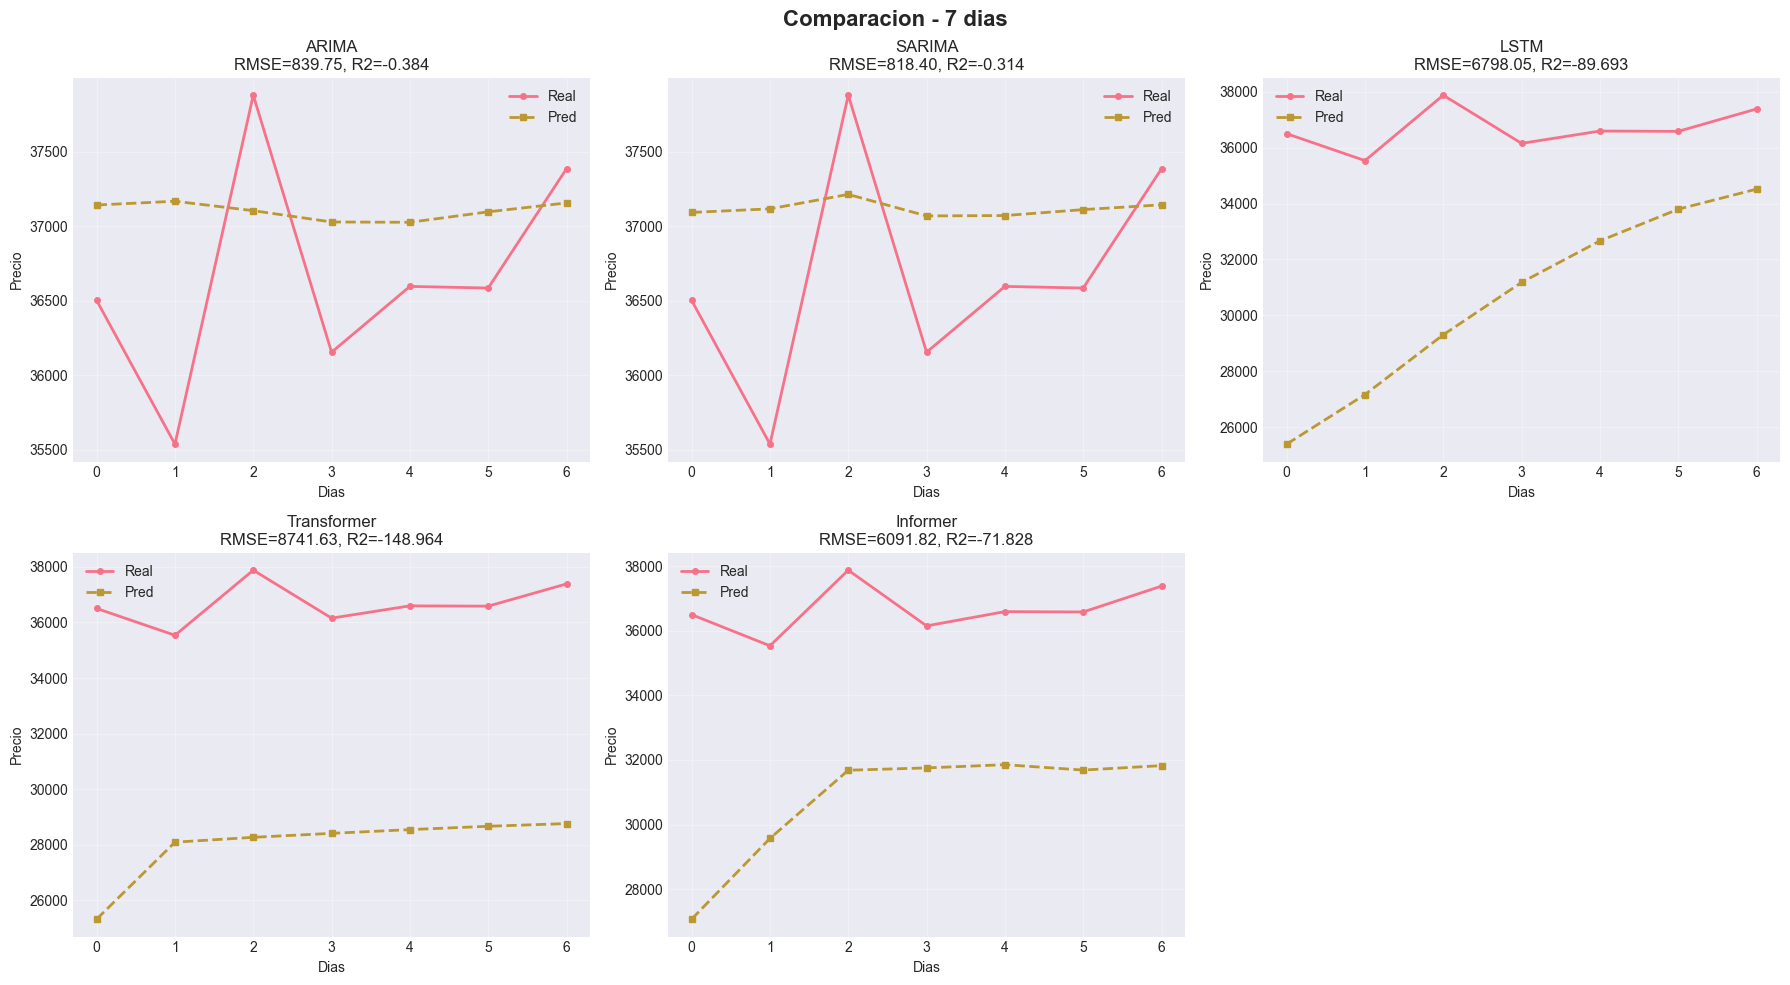

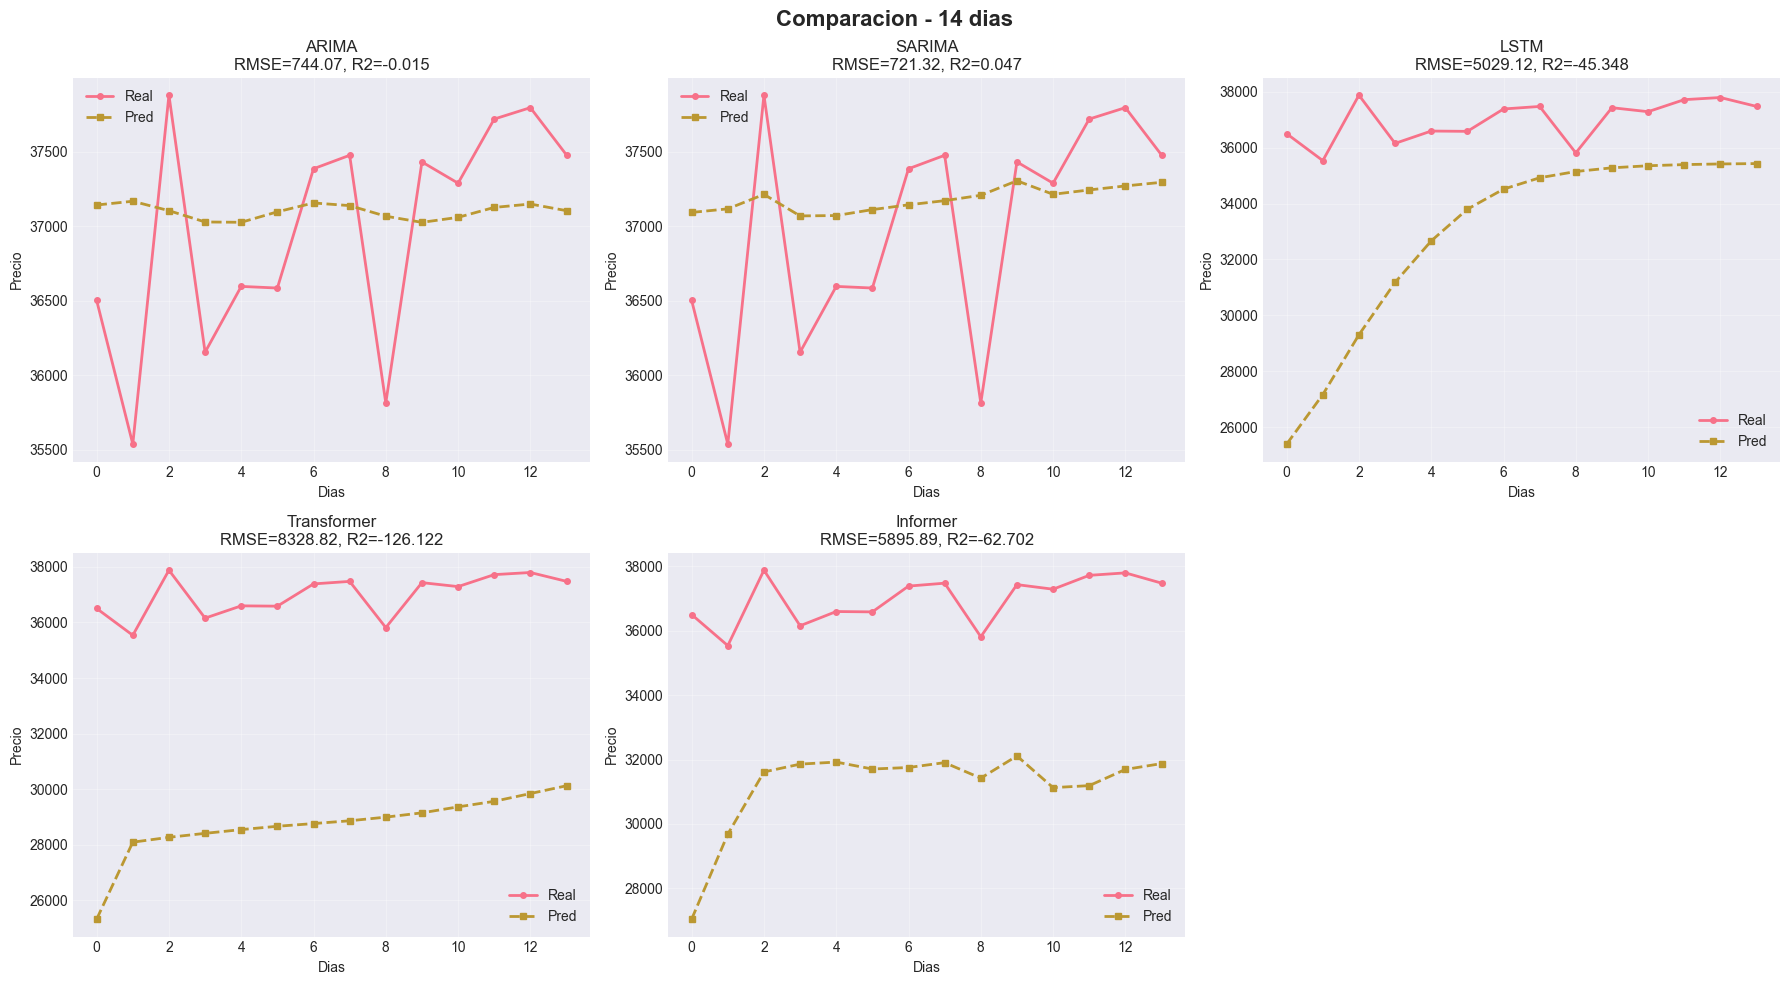

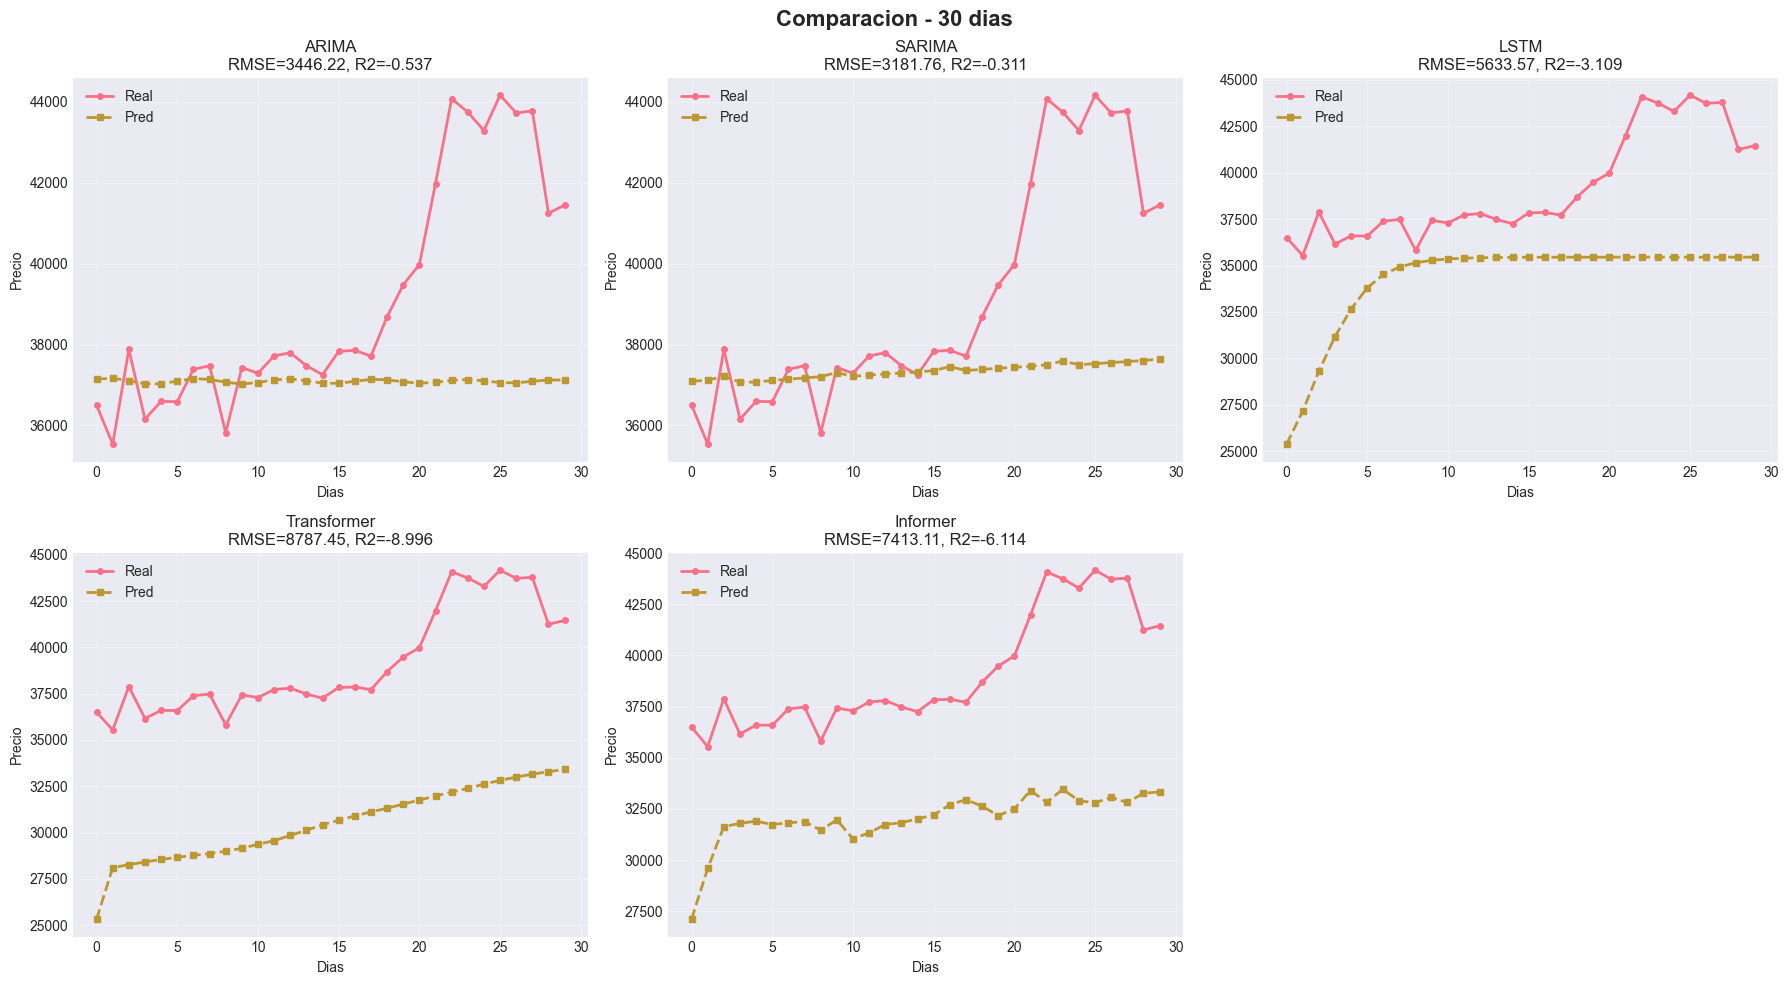


ANALISIS COMPLETO FINALIZADO
Resultados en: final_st2_results_v3/


In [18]:
# Visualizacion
for horizon in CONFIG['forecast_horizons']:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Comparacion - {horizon} dias', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    idx = 0
    for model_name, forecasts in all_results.items():
        if horizon in forecasts and idx < len(axes):
            ax = axes[idx]
            actual = forecasts[horizon]['actual']
            forecast = forecasts[horizon]['forecast']
            metrics = forecasts[horizon]['metrics']
            
            x = np.arange(len(actual))
            ax.plot(x, actual, 'o-', label='Real', linewidth=2, markersize=4)
            ax.plot(x, forecast, 's--', label='Pred', linewidth=2, markersize=4)
            ax.set_title(f"{model_name}\nRMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.3f}")
            ax.set_xlabel('Dias')
            ax.set_ylabel('Precio')
            ax.legend()
            ax.grid(True, alpha=0.3)
            idx += 1
    
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/comparison_{horizon}d.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("ANALISIS COMPLETO FINALIZADO")
print(f"Resultados en: {CONFIG['output_dir']}/")
print("="*60)

## 14. Resumen

In [19]:
print("\n" + "="*60)
print("RESUMEN DE MODELOS")
print("="*60)
print(f"\nDirectorio: {CONFIG['output_dir']}/")
print("\nArchivos generados:")
for f in sorted(os.listdir(CONFIG['output_dir'])):
    print(f"  - {f}")

print("\n" + "="*60)
print("ARQUITECTURAS UTILIZADAS (IMPORTADAS DE src/models/)")
print("="*60)
print("\n1. LSTM (src/models/lstm_model.py)")
print(f"   - Hidden dim: 128")
print(f"   - Num layers: 3")
print(f"   - Dropout: 0.1")
print(f"   - Parametros: {sum(p.numel() for p in lstm_model.parameters()):,}")

print("\n2. Transformer (src/models/transformer_model.py)")
print(f"   - d_model: 128")
print(f"   - nhead: 8")
print(f"   - num_layers: 3")
print(f"   - dim_feedforward: 512")
print(f"   - Parametros: {sum(p.numel() for p in transformer_model.parameters()):,}")

print("\n3. Informer (src/models/informer_model.py)")
print(f"   - d_model: 512")
print(f"   - n_heads: 8")
print(f"   - e_layers: 2")
print(f"   - d_ff: 2048")
print(f"   - factor: 5 (ProbSparse attention)")
print(f"   - Parametros: {sum(p.numel() for p in informer_model.parameters()):,}")

print("\n" + "="*60)
print("ANALISIS COMPLETADO EXITOSAMENTE")
print("="*60)


RESUMEN DE MODELOS

Directorio: final_st2_results_v3/

Archivos generados:
  - 01_EDA.png
  - comparison_14d.csv
  - comparison_14d.png
  - comparison_30d.csv
  - comparison_30d.png
  - comparison_7d.csv
  - comparison_7d.png
  - informer_model.pth
  - lstm_model.pth
  - transformer_model.pth

ARQUITECTURAS UTILIZADAS (IMPORTADAS DE src/models/)

1. LSTM (src/models/lstm_model.py)
   - Hidden dim: 128
   - Num layers: 3
   - Dropout: 0.1
   - Parametros: 376,071

2. Transformer (src/models/transformer_model.py)
   - d_model: 128
   - nhead: 8
   - num_layers: 3
   - dim_feedforward: 512
   - Parametros: 803,463

3. Informer (src/models/informer_model.py)
   - d_model: 512
   - n_heads: 8
   - e_layers: 2
   - d_ff: 2048
   - factor: 5 (ProbSparse attention)
   - Parametros: 7,134,215

ANALISIS COMPLETADO EXITOSAMENTE
